<a href="https://colab.research.google.com/github/tncourtz/RL-EV-CS-Energy-Management-System/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **24-hour LSTM v1**

In [ ]:
# Import required libraries
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Reshape
from keras.layers import Dropout
from keras.layers import LSTM
import math
from math import sqrt
from math import sqrt
from matplotlib import pyplot as plt
import numpy as np
import os
import platform
import pickle
import random
import progressbar
from IPython.display import clear_output
from collections import deque

In [ ]:
#Upload Data file to drive
from google.colab import files
uploaded = files.upload()

Saving trr.csv to trr.csv


In [ ]:
#read the data from the file
df = read_csv('trr.csv', header=0, parse_dates=[0], index_col=0)

In [ ]:
def timeseries_to_supervised(data, lag=1):
    """
    This function frames a sequence as a supervised learning problem
    
    Args:
        1) data --> time series
        2) lag --> number of lagged features to be generated
    Out:
        1) df -> dataframe containing all the lagged features (from the more recent to the more lagged)
                 the last column of the dataframe is the initial time series (target of the supervised learning model)
    
    Lagged features are generated as continous in time. Id est, if 3 is the number of lagged features and t is the actual time, 
    generated features will be the actual series lagged at t-1, t-2, t-3
    """
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    #df = df.dropna()
    return df

def difference(dataset, interval=1):
    """
    This function create a differenced series to remove seasonality effects
    
    Args:
        1) dataset -> time series
    Out:
        1) Pandas Series of the differenced initial dataframe
    """
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return Series(diff)

def inverse_difference(history, yhat, interval):
    """
    This function invert differenced values.
    
    Args:
        1) history -> time series to be predicted
        2) yhat -> predicted value
        3) interval -> difference interval
    
    Out:
        1) Anti-transformed predicted value
    """
    return yhat + history.iloc[-interval]

In [ ]:
def scale_fit(dataset, scaler=MinMaxScaler(feature_range=(-1, 1))):
    """
    Fit a scaler on a dataset
    
    Args:
        1) dataset --> train dataset
        2) scaler --> scaler to be fitted
        
    Out:
        1) scaler -> fitted scaler
    """
    
    # fit scaler
    scaler = scaler.fit(dataset)
    
    return scaler

def scale_transform(dataset, scaler):
    """
    Apply fitted scaler to a dataset
    
    Args:
        1) dataset to be transformed
        2) scaler (alreasy fitted)
        
    Out:
        1) fitted dataset
    """
    dataset = dataset.reshape(dataset.shape[0], dataset.shape[1])
    dataset_scaled = scaler.transform(dataset)
    
    return dataset_scaled


def invert_scale(scaler, X, value):
    """
    This function performs inverse scaling for a forecasted value
    
    Args:
        1) scaler -> fitted scaler with scale() function
        2) X -->
        3) value -->
    Out:
        1) unscaled value
    """
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [ ]:
def split_features_label(dataset):
    """
    This function splits datafrema in label and features
    
    Args:
        1) dataset -> input dataset, target variable is the last column
    Out:
        1) features -> model features matrix
        2) label -> supervised model label array
    
    IMPORTANT: assumptions about labels:
        1) Only one output (forecast at time t+n, when n is the number of steps ahead)
        2) label array must be the last column of the dataset matrix
        
    """
    features, label = dataset[:, 0:-1], dataset[:, -1]
    features = features.reshape(features.shape[0], 1, features.shape[1])
    return features,label

def fit_lstm(train, val, batch_size, nb_epoch, neurons):
    """
    This function fits an LSTM network to training data
    
    Args:
        1) train --> training dataset
        2) val --> validation dataset
        3) batch_size
        4) nb_epochs --> number of epochs
        5) neurons --> number of neurons in the hidden layer
    
    Out:
        1) model --> trained model
    """
    X, y = split_features_label(train)
    X_val, y_val = split_features_label(val)
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in tqdm_notebook(range(nb_epoch),leave=False):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False, validation_data=(X_val,y_val))
        model.reset_states()
    return model

def forecast_lstm(model, batch_size, X):
    """
    This function makes a one-step forecast
    
    Args:
        1) model --> supervised model (fitted by fit_lstm function)
        2) batch_size
        3) X --> input features
    """
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [ ]:
params = {
    'mkt': 'power',
    'path_to_file' : {
        'path_to_pickle' : '../saved_session/',
        'pickle_name' : 'electric_mkt_data.pkl',
        'path_to_data' : '../data/',
        'data_prefix' : 'elspot-prices_',
        'data_suffix' : '_hourly_dkk.csv'
    },
    'dataset' : {
        'val_share' : 0.2,
        'n_steps' : 24,
        'time_ahead' : 1
    },
    'arch' : {
        'n_ensemble' : 1,
        'neurons' : 5,
        'epochs' : 10,
        'batch_size': 1
    }
}

In [ ]:
def etl_pipeline(params, df):
    
    # internal paramters for the LSTM model
    n_shift = params['dataset']['n_steps'] + params['dataset']['time_ahead'] - 1
    n_ahead = range(0,params['dataset']['time_ahead'])
    
    # data loading and feature extraction
    df = df
    raw_values = df[params['mkt']].dropna()
    diff_values = difference(raw_values, interval = params['dataset']['time_ahead'])
    supervised = timeseries_to_supervised(diff_values, n_shift)
    supervised_values = supervised.values
    
    # train - validation split
    test_size = round(params['dataset']['val_share']*supervised_values.shape[0])
    train_size = supervised_values.shape[0]-test_size
    train, test = supervised_values[0:train_size,:], supervised_values[train_size:,:]
    if len(n_ahead)>0:
        train, test = np.delete(train, n_ahead, axis = 1),np.delete(test, n_ahead, axis = 1)
        
    # feature scaling
    scaler = scale_fit(train)
    train_scaled = scale_transform(train, scaler)
    test_scaled = scale_transform(test, scaler)    
    return scaler, train_scaled, test_scaled, train, test, raw_values

In [ ]:
scaler, train_scaled, test_scaled, train, test, raw_values = etl_pipeline(params, df)

In [ ]:
# fit the model
lstm_ensemble = list()
for n in tqdm_notebook(range(params['arch']['n_ensemble'])):
    lstm_model = fit_lstm(train_scaled, 
                          test_scaled, 
                          params['arch']['batch_size'], 
                          params['arch']['epochs'], 
                          params['arch']['neurons'])
    lstm_ensemble.append(lstm_model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
def make_predictions(lstm_model,test_scaled,scaler,raw_values):
    """
    This function makes prediction on a test dataset using a fitted LSTM model
    
    Args:
        1) lstm_model -> fitted model
        2) test_scaled -> test dataset already preprocessed and scaled
        3) scaler --> required to unscale model input data
        4) raw_values --> required to undo time difference
    Out:
        1) predictions -> model forecasted values for the testset
    
    """
    
    # walk-forward validation on the test data
    predictions = list() 
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
    return predictions

In [ ]:
def evaluate_model_performance(lstm_ensemble, test_scaled, raw_values, scaler):
    """
    This function estimates model performance, calculating relevant metrics
    
    Args:
        1) lstm_ensemble --> a list of models to be evaluated
        2) test_scaled --> test set to be used for metrics calculation
        3) raw_values --> inital unscaled dataset for benchmark
        4) scaler --> fitted scaler (necessary to unscale model input data)
        
    Out:
        1) rmse_ensemble --> a list of RMSE (one for each model)
        2) mae_ensemble --> a list of MAE (one for each model)
        3) predictions_ensemble --> a list of predicted values (one for each model)
    
    This function supports the evaluation of a single model (one-item list)
    
    """
    rmse_ensemble = list()
    mae_ensemble = list()
    predictions_ensemble = list()
    test_samples = test_scaled.shape[0]
    for i in tqdm_notebook(range(len(lstm_ensemble))):
        predictions = make_predictions(lstm_ensemble[i],test_scaled, scaler,raw_values)
        predictions_ensemble.append(predictions)
        rmse = sqrt(mean_squared_error(raw_values[-test_samples:], predictions))
        rmse_ensemble.append(rmse)
        mae = mean_absolute_error(raw_values[-test_samples:], predictions)
        mae_ensemble.append(mae)
    return rmse_ensemble, mae_ensemble, predictions_ensemble

In [ ]:
def print_performance_metrics(rmse_ensemble,mae_ensemble):
    if len(rmse_ensemble)==len(mae_ensemble):
        if len(rmse_ensemble)>1:
            rmse = np.mean(np.array(rmse_ensemble))
            std_rmse = np.std(np.array(rmse_ensemble))
            mae = np.mean(np.array(mae_ensemble))
            std_mae = np.std(np.array(mae_ensemble))
            msg = 'AVG RMSE: {} STD RMSE: {} \n AVG MAE: {} STD MAE: {}'
            print(msg.format(rmse,std_rmse,mae,std_mae))
        else:
            msg = 'RMSE: {} \n MAE: {}'
            rmse = rmse_ensemble[0]
            mae = mae_ensemble[0]
            print(msg.format(rmse,mae))
    else:
        print('Array size mismatch!')
    return rmse, mae

In [ ]:
def plot_sample_predictions(predictions_ensemble,raw_values,n_model=0,n_day=1):
    """
    This function plots observed vs predicted values for a fixed period of time
    
    Args:
        1) predictions_ensemble --> a list of predictions (one for each model)
        2) n_model --> which model of the ensemble is selected
        3) n_day --> how many days are plotted
    
    The function returns a matplotlib line plot
    """
    subset=24*n_day
    model_predictions = predictions_ensemble[n_model]
    
    plt.figure(figsize=(15,7))
    plt.title('Model results on validation set')
    plt.xlabel('Time [Hours]')
    plt.ylabel('Electricity Price [DKK]')
    plt.plot(range(subset),raw_values[-subset:],color = 'b')
    plt.plot(range(subset),model_predictions[-subset:], color = 'r')
    plt.legend(['real','forecast'])
    plt.show()
    return

In [ ]:
t_try = 24
rmse_list = list()
mae_list = list()

In [ ]:
for t in tqdm_notebook(range(t_try)):
    
    params['dataset']['time_ahead'] = t

    scaler, train_scaled, test_scaled, train, test, raw_values = etl_pipeline(params, df)
    
    # fit the model
    lstm_ensemble = list()
    for n in tqdm_notebook(range(params['arch']['n_ensemble'])):
        lstm_model = fit_lstm(train_scaled, 
                              test_scaled, 
                              params['arch']['batch_size'], 
                              params['arch']['epochs'], 
                              params['arch']['neurons'])
        lstm_ensemble.append(lstm_model)

    # validation set
    rmse_ensemble, mae_ensemble, predictions_ensemble = evaluate_model_performance(lstm_ensemble, 
                                                                                   test_scaled, 
                                                                                   raw_values,
                                                                                   scaler)

    rmse, mae =  print_performance_metrics(rmse_ensemble,mae_ensemble)
    
    msg = 'model: time lag {}h, RMSE: {},MAE: {}'
    print(msg.format(t, rmse, mae))
    rmse_list.append(rmse)
    mae_list.append(mae)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



RMSE: 3.920581335029322 
 MAE: 2.9011673304541357
model: time lag 0h, RMSE: 3.920581335029322,MAE: 2.9011673304541357


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



RMSE: 4.19646260039878 
 MAE: 3.1207056866459597
model: time lag 1h, RMSE: 4.19646260039878,MAE: 3.1207056866459597


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



RMSE: 4.112625180701575 
 MAE: 3.3562620326858665
model: time lag 2h, RMSE: 4.112625180701575,MAE: 3.3562620326858665


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



RMSE: 4.164309606945049 
 MAE: 3.51414737565247
model: time lag 3h, RMSE: 4.164309606945049,MAE: 3.51414737565247


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



RMSE: 4.6366319147515185 
 MAE: 3.9428724064508045
model: time lag 4h, RMSE: 4.6366319147515185,MAE: 3.9428724064508045


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



RMSE: 5.272704873841873 
 MAE: 4.420673383014693
model: time lag 5h, RMSE: 5.272704873841873,MAE: 4.420673383014693


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



RMSE: 5.268474527368252 
 MAE: 4.165577153741035
model: time lag 6h, RMSE: 5.268474527368252,MAE: 4.165577153741035


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



RMSE: 5.655705594007047 
 MAE: 4.311449782598897
model: time lag 7h, RMSE: 5.655705594007047,MAE: 4.311449782598897


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



RMSE: 6.3105636840890265 
 MAE: 4.995352888634165
model: time lag 8h, RMSE: 6.3105636840890265,MAE: 4.995352888634165


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



RMSE: 6.941184103759515 
 MAE: 5.616661836079188
model: time lag 9h, RMSE: 6.941184103759515,MAE: 5.616661836079188


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



RMSE: 6.583872008067679 
 MAE: 5.475546955228119
model: time lag 10h, RMSE: 6.583872008067679,MAE: 5.475546955228119


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



RMSE: 6.576984883843624 
 MAE: 5.353976448983967
model: time lag 11h, RMSE: 6.576984883843624,MAE: 5.353976448983967


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



RMSE: 7.62060348090412 
 MAE: 6.07009888436138
model: time lag 12h, RMSE: 7.62060348090412,MAE: 6.07009888436138


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



RMSE: 7.409715927477903 
 MAE: 6.028811468121681
model: time lag 13h, RMSE: 7.409715927477903,MAE: 6.028811468121681


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



RMSE: 9.13290542390259 
 MAE: 7.302299863511698
model: time lag 14h, RMSE: 9.13290542390259,MAE: 7.302299863511698


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



RMSE: 9.691347832435595 
 MAE: 8.02109389597018
model: time lag 15h, RMSE: 9.691347832435595,MAE: 8.02109389597018


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



RMSE: 7.905438668358977 
 MAE: 6.653810933549644
model: time lag 16h, RMSE: 7.905438668358977,MAE: 6.653810933549644


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



RMSE: 8.047541458170555 
 MAE: 6.616795003535482
model: time lag 17h, RMSE: 8.047541458170555,MAE: 6.616795003535482


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



RMSE: 6.298994265051785 
 MAE: 5.0496782139992265
model: time lag 18h, RMSE: 6.298994265051785,MAE: 5.0496782139992265


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



RMSE: 6.699100844420243 
 MAE: 4.8293028369283775
model: time lag 19h, RMSE: 6.699100844420243,MAE: 4.8293028369283775


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



RMSE: 5.645619108087209 
 MAE: 4.08867913123289
model: time lag 20h, RMSE: 5.645619108087209,MAE: 4.08867913123289


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



RMSE: 5.059630049028982 
 MAE: 3.740914666223044
model: time lag 21h, RMSE: 5.059630049028982,MAE: 3.740914666223044


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



RMSE: 5.329282820652317 
 MAE: 4.346120997545013
model: time lag 22h, RMSE: 5.329282820652317,MAE: 4.346120997545013


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



RMSE: 5.998913325012883 
 MAE: 4.460787664406119
model: time lag 23h, RMSE: 5.998913325012883,MAE: 4.460787664406119



In [ ]:
df_lstm_performance = pd.DataFrame({'lag':range(24),'rmse':rmse_list,'mae':mae_list})
print(df_lstm_performance)

    lag      rmse       mae
0     0  3.920581  2.901167
1     1  4.196463  3.120706
2     2  4.112625  3.356262
3     3  4.164310  3.514147
4     4  4.636632  3.942872
5     5  5.272705  4.420673
6     6  5.268475  4.165577
7     7  5.655706  4.311450
8     8  6.310564  4.995353
9     9  6.941184  5.616662
10   10  6.583872  5.475547
11   11  6.576985  5.353976
12   12  7.620603  6.070099
13   13  7.409716  6.028811
14   14  9.132905  7.302300
15   15  9.691348  8.021094
16   16  7.905439  6.653811
17   17  8.047541  6.616795
18   18  6.298994  5.049678
19   19  6.699101  4.829303
20   20  5.645619  4.088679
21   21  5.059630  3.740915
22   22  5.329283  4.346121
23   23  5.998913  4.460788


[[16.537497681500362, 13.52088892295954, 10.915427131056758, 11.61289072073062, 9.074519302621454, -0.9988478867942749, -1.3259911611257402, 0.5349121013120465, -2.3144669981394244, -5.320636383388219, -3.672899346258519, 13.17618633256291, 19.318359431363614, 18.516494531184406, 19.215736202076048, 17.7677922119945, 9.338210280891479, 8.408771427292347, 11.715560087673337, 15.548790581123875, 16.01907120204528, 24.29275162193921, 25.463925031609804, 17.599945431100174, 18.68334027029571, 19.564935340387716, 17.445811109282047, 12.871032670941176, 12.94554954483171, 3.531144867248339, -0.2756271896162353, 1.8357572077214432, 3.674551726812468, 11.064083522241534, -1.7901038835943026, 6.197323919255258, 11.609357341919068, 11.159871867895099, 14.324471282863495, 20.4741418260615, 17.284013549238413, 16.880762264495687, 15.786274610047666, 16.102420569846846, 13.66644018453543, 13.343735193759176, 15.78606776167636, 14.197013932520031, 14.591896001903777, 16.893594668749692, 19.999338952

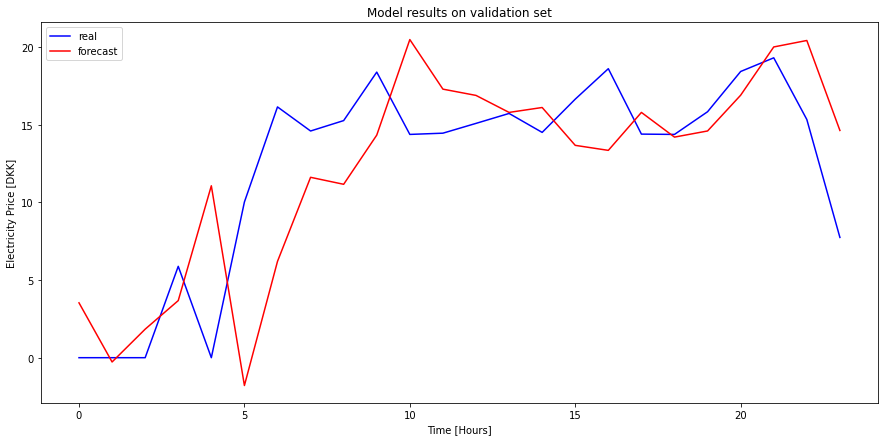

In [ ]:
print(predictions_ensemble)
plot_sample_predictions(predictions_ensemble,raw_values)

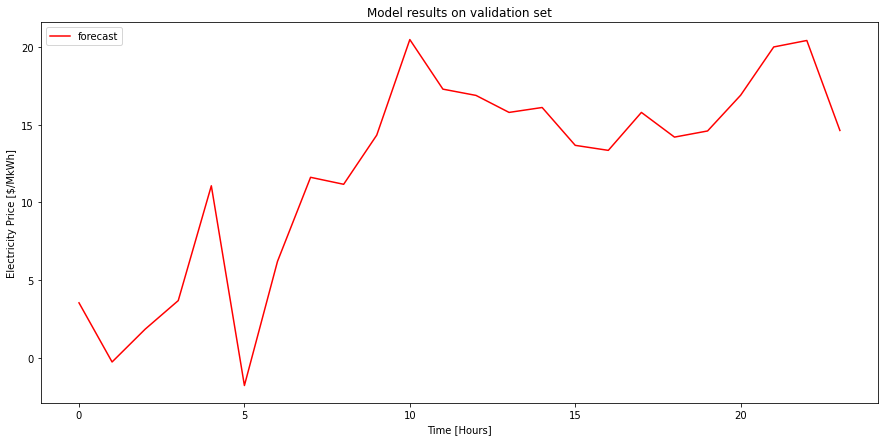

[]

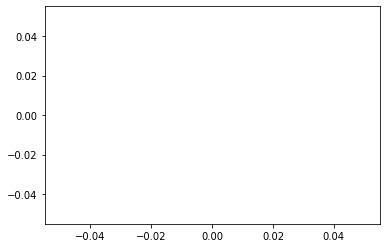

In [ ]:
subset=24
sub = 128
model_predictions = np.concatenate(([float('nan')]*104, predictions_ensemble[0][-subset:] ))
# 
plt.figure(figsize=(15,7))
plt.title('Model results on validation set')
plt.xlabel('Time [Hours]')
plt.ylabel('Electricity Price [$/MkWh]')
# plt.plot(range(sub),raw_values[-sub:],color = 'b')
plt.plot(range(subset),model_predictions[-subset:], color = 'r')
# plt.legend(['real','forecast'])
plt.legend(['forecast'])
plt.show()
plt.plot()

In [ ]:
model_predictions = predictions_ensemble[0][-subset:]
print(model_predictions)

[3.531144867248339, -0.2756271896162353, 1.8357572077214432, 3.674551726812468, 11.064083522241534, -1.7901038835943026, 6.197323919255258, 11.609357341919068, 11.159871867895099, 14.324471282863495, 20.4741418260615, 17.284013549238413, 16.880762264495687, 15.786274610047666, 16.102420569846846, 13.66644018453543, 13.343735193759176, 15.78606776167636, 14.197013932520031, 14.591896001903777, 16.893594668749692, 19.999338952619556, 20.41547623384741, 14.624669262506039]


# **24-hour LSTM v2**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving trr.csv to trr.csv


In [ ]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series
import math 
import random
import progressbar
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from pandas.tseries.offsets import DateOffset
from IPython.display import clear_output
from collections import deque
import pandas as pd
import numpy as np
import datetime
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Reshape
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from pandas.tseries.offsets import DateOffset

df = read_csv('trr.csv', header=0, parse_dates=[0], index_col=0)


In [ ]:

n_data = len(df)
train, test = df[0:124], df[124:]
scaler = MinMaxScaler()
scaler.fit(train)
scaler.fit(test)

test = scaler.transform(test)
train = scaler.transform(train)


In [ ]:
n_input = 24
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=2)

In [ ]:
model = Sequential()
model.add(LSTM(180, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator, epochs=180)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/180
50/50 [==============================] - 1s 22ms/step - loss: 0.1065
Epoch 2/180
50/50 [==============================] - 1s 22ms/step - loss: 0.0956
Epoch 3/180
50/50 [==============================] - 1s 20ms/step - loss: 0.0917
Epoch 4/180
50/50 [==============================] - 1s 20ms/step - loss: 0.0957
Epoch 5/180
50/50 [==============================] - 1s 21ms/step - loss: 0.0888
Epoch 6/180
50/50 [==============================] - 1s 20ms/step - loss: 0.0880
Epoch 7/180
50/50 [==============================] - 1s 20ms/step - loss: 0.0893
Epoch 8/180
50/50 [==============================] - 1s 20ms/step - loss: 0.0886
Epoch 9/180
50/50 [==============================] - 1s 21ms/step - loss: 0.0870
Epoch 10/180
50/50 [==============================] - 1s 20ms/step - loss: 0.0852
Epoch 11/180
50/50 [==============================] - 1s 22ms/step - loss: 0.0906
Epoch 12/180
50/50 [===========

In [ ]:
prediction_list = []
batch = test[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):
    prediction_list.append(model.predict(batch)[0])
    batch = np.append(batch[:, 1:, :], [[prediction_list[i]]], axis=1)

df_prediction = pd.DataFrame(scaler.inverse_transform(prediction_list), index=df[-n_input:].index, columns=['prediction'])

df_tests = pd.concat([df, df_prediction], axis=1)

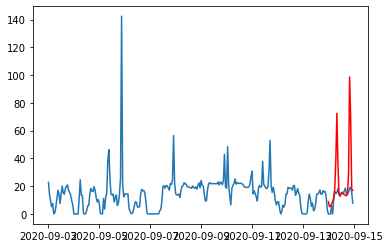

In [ ]:
pyplot.plot(df_tests.index, df_tests['power'], label='original')
pyplot.plot(df_tests.index, df_tests['prediction'], color='red', label='prediction')
pyplot.show()

In [ ]:
n_input = 24
n_features = 1
train = df
scaler.fit(train)
train = scaler.transform(train)
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=5)
model.fit_generator(generator, epochs=100)
prediction_list = []
batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):
    prediction_list.append(model.predict(batch)[0])
    batch = np.append(batch[:, 1:, :], [[prediction_list[i]]], axis=1)

Epoch 1/100
44/44 [==============================] - 1s 25ms/step - loss: 0.0240
Epoch 2/100
44/44 [==============================] - 1s 25ms/step - loss: 0.0253
Epoch 3/100
44/44 [==============================] - 1s 25ms/step - loss: 0.0240
Epoch 4/100
44/44 [==============================] - 1s 25ms/step - loss: 0.0223
Epoch 5/100
44/44 [==============================] - 1s 26ms/step - loss: 0.0221
Epoch 6/100
44/44 [==============================] - 1s 25ms/step - loss: 0.0217
Epoch 7/100
44/44 [==============================] - 1s 25ms/step - loss: 0.0206
Epoch 8/100
44/44 [==============================] - 1s 25ms/step - loss: 0.0224
Epoch 9/100
44/44 [==============================] - 1s 25ms/step - loss: 0.0227
Epoch 10/100
44/44 [==============================] - 1s 25ms/step - loss: 0.0193
Epoch 11/100
44/44 [==============================] - 1s 24ms/step - loss: 0.0207
Epoch 12/100
44/44 [==============================] - 1s 25ms/step - loss: 0.0214
Epoch 13/100
44/44 [=====

In [ ]:
print(df.index[-1])

2020-09-12 23:00:00


In [ ]:
add_dates = [df.index[-1] + DateOffset(hours=x) for x in range(0, 25)]
future_dates = pd.DataFrame(index=add_dates[1:], columns=df.columns)

In [ ]:
df_prediction = pd.DataFrame(scaler.inverse_transform(prediction_list), index=future_dates[-n_input:].index, columns=['prediction'])
df_proj = pd.concat([df, df_prediction], axis=1)

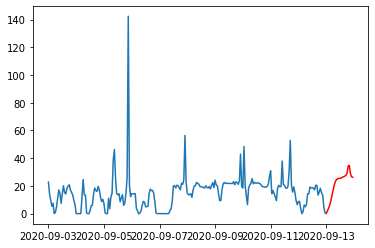

In [ ]:
pyplot.plot(df_proj.index, df_proj['power'], label='original')
pyplot.plot(df_proj.index, df_proj['prediction'], color='red', label='prediction')
pyplot.show()